## Privacy-Preserving Statistical Release
### Analysis of OSMI data 
#### Mental Health in Tech Survey

The purpose of this demo is to showcase the utility of the OpenDP whitenoise library. The notebook will focus on statistical releases in the *trusted curator* setting.

Through out his notebook, we make statistical queries to data with and without privacy-preserving mechanisms. As we compare query results side-by-side, we show that conclusions about the data are similar in both settings: without privacy-preserving mechanism, and with differential privacy mechanism. More precisely, the goals of this tutorial are:

- serve an audience with basic understanding of differential privacy;
- focus on reproducibility by using open data;
- showcase the easy usability of the whitenoise package;
- focus on utility.


**Disclaimer:** The present notebook is not intended to serve as a study of mental illness in the tech industry, or make any conclusions about the scenario of mental illness in tech. We use the data set as a illustrative example of the whitenoise tool in survey and human subject studies.

## 1 Data set

Mental health in tech survey data set is an open data set licensed under CC BY-SA 4.0. 

The data consists in 27 questions, aswered by 1,259 volunteers. For details on the data set, we refer the reader to https://www.kaggle.com/osmi/mental-health-in-tech-survey

The data used in the analysis was preprocessed. The original age, gender and country variables were maped into categories for our analysis. We refer the reader to the [preprocessing notebook](Data set processing - Mental Health in Tech Survey.ipynb) for details on variable mappings.

The analysis will be focused on the following variables:
- **age**: age of the participant. Categorical variable with 5 categories: 21-30yo (0), 31-40yo (1), 41-50yo (2), 51-60yo (3), 60yo+ (4) 
- **gender**: gender declared by the participant, and in the survey the participants could input any string. We categorized answers as follows: Male/Man (1), Female/Woman(2), all other inputs (0).
- **country**: participant's country of residence. We categorized answers as follows: United States (1), United Kingdom (2), Canada (3), other countries (0).
- **remote_work**: binary value that indicates 
    if participant work remotely more than 50% of the time
- **family_history**: binary value that indicates if the 
    participant has a family history of mental illness 
- **treatment**: Binary value that 
    indicates if the participants has seeked 
    treatment for mental illness

## 2 Data Analysis and Exploration

In [4]:
##Import packages
import os

import whitenoise as wn
import whitenoise.components as op

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import numpy as np
import pandas as pd
import scipy.stats as ss

import seaborn as sns
sns.set(style = "whitegrid")

%matplotlib inline

In [2]:
path = 'survey_V2.csv'

In [3]:
survey = pd.read_csv(path)
print('Data length: '+ str(len(survey)))
survey.head()

Data length: 1213


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments,age,gender,country
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,0,1,Often,6-25,...,Some of them,Yes,No,Maybe,Yes,No,NaN,1,2,1
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,0,0,Rarely,More than 1000,...,No,No,No,No,Don't know,No,NaN,2,1,1
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,0,0,Rarely,6-25,...,Yes,Yes,Yes,Yes,No,No,NaN,1,1,3
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,1,1,Often,26-100,...,Some of them,No,Maybe,Maybe,No,Yes,NaN,1,1,2
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,0,0,Never,100-500,...,Some of them,Yes,Yes,Yes,Don't know,No,NaN,1,1,1


### 2.1 Characteristics of survey participants

In the following analysis we explore the distribution of participants according to the following variables:
- age;
- gender;
- country;
- remote_work;
- family_history; 
- treatment.

We make simple histogram queries for each of the variables.

In [14]:
# For multicategorical variables, we define the categories as lists
age_cat =['0','1','2','3','4']

country_cat = ['0','1','2','3']

gender_cat = ['0', '1', '2']

var_names =list(survey.columns)
with wn.Analysis() as analysis:
    data = wn.Dataset(path = path, column_names = var_names)
#Releases with Geometric Mechanism        
    age_histogram = op.dp_histogram(
            data['age'],
            categories = age_cat,
            null_value = "4",
            privacy_usage = {'epsilon': 0.1}
        )
    gender_histogram = op.dp_histogram(
            data['gender'],
            categories = gender_cat,
            null_value = '0',
            privacy_usage = {'epsilon': 0.1}
        )
    country_histogram = op.dp_histogram(
            data['country'],
            categories = country_cat,
            null_value = '0',
            privacy_usage = {'epsilon': 0.1}
        )
    remotework_histogram = op.dp_histogram(
            op.cast(data['remote_work'], type='bool', true_label="1"),
            upper = 1213,
            privacy_usage = {'epsilon': 0.1}
        )
    
    family_histogram = op.dp_histogram(
            op.cast(data['family_history'], type='bool', true_label="1"),
            upper = 1213,
            privacy_usage = {'epsilon': 0.1}
        )
    
    treatment_histogram = op.dp_histogram(
            op.cast(data['treatment'], type='bool', true_label="1"),
            upper = 1213,
            privacy_usage = {'epsilon': 0.1}
        )
    
    

analysis.release()

print("Age histogram Geometric DP release:" + str(np.absolute(age_histogram.value)))
print("Country histogram Geometric DP release:" + str(np.absolute(country_histogram.value)))
print("Gender histogram Geometric DP release:" + str(np.absolute(gender_histogram.value)))
print("Remote Work histogram Geometric DP release:" + str(np.absolute(remotework_histogram.value)))
print("family history histogram Geometric DP release:" + str(np.absolute(family_histogram.value)))
print("treatment histogram Geometric DP release:" + str(np.absolute(treatment_histogram.value)))

Age histogram Geometric DP release:[496 553 187  23   6]
Country histogram Geometric DP release:[250 827 171  60]
Gender histogram Geometric DP release:[  9 957 259]
Remote Work histogram Geometric DP release:[385 854]
family history histogram Geometric DP release:[473 714]
treatment histogram Geometric DP release:[549 576]


Due to sequential composition, given $q_i$ queries, where each provide $\epsilon_i$-*differential privacy*, the sequence of queries provides $(\sum \epsilon_i)$-*differential privacy*. 

In [17]:
def pie_comparison(label, true_counts, dp_counts, title, subtitle1, subtitle2):
    # Make square figures and axes
    plt.figure(1, figsize=(20,25))
    the_grid = GridSpec(2, 2)
    plt.rcParams['text.color'] = '#000000'
    plt.rcParams['axes.labelcolor']= '#000000'
    plt.rcParams['xtick.color'] = '#000000'
    plt.rcParams['ytick.color'] = '#000000'
    plt.rcParams['font.size']=14

    cmap = plt.get_cmap('GnBu')
    colors = [cmap(i) for i in np.linspace(0, 1, 8)]


    plt.subplot(the_grid[0, 0], aspect=1, title= subtitle1)

    source_pie = plt.pie(true_counts, labels=label, autopct='%1.1f%%', shadow=True, colors=colors)


    plt.subplot(the_grid[0, 1], aspect=1, title= subtitle2)

    flavor_pie = plt.pie(dp_counts,labels=label, autopct='%.0f%%', shadow=True, colors=colors)

    plt.suptitle(title, fontsize=24)


    plt.show()

### Age Distribution

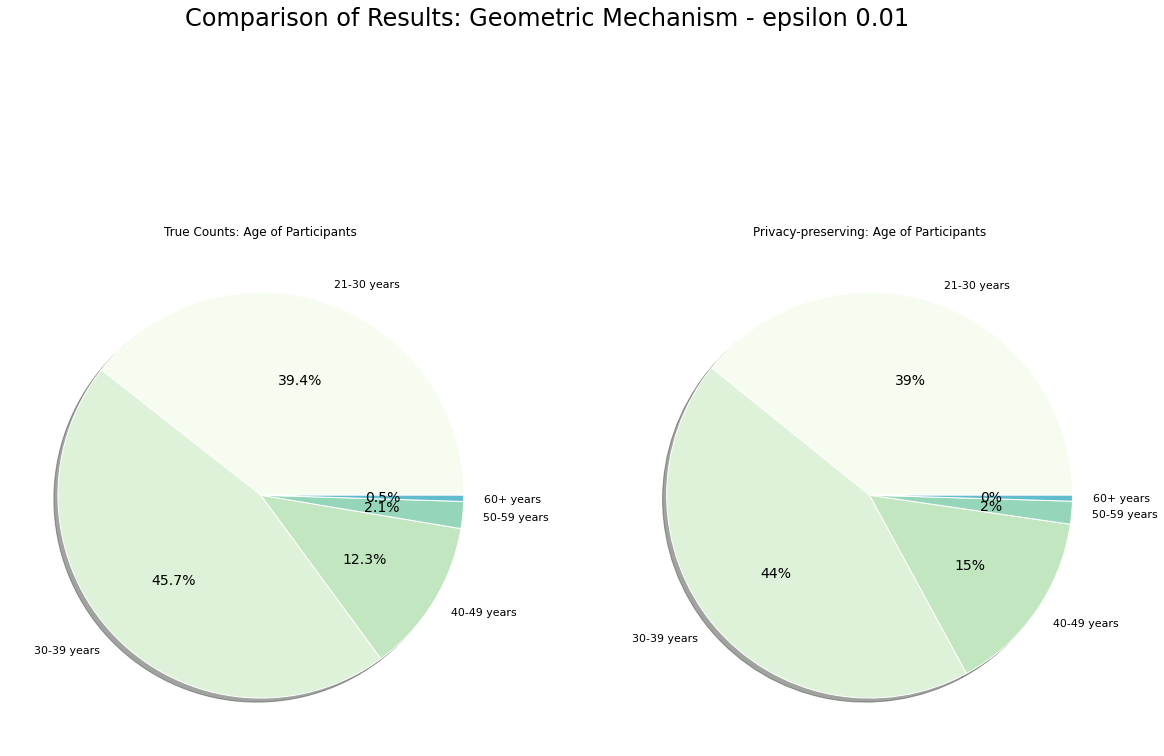

In [18]:
age_true = [478, 554, 149, 26, 6]
age_geo = age_histogram.value
epsilon_ = 0.01
age_labels = ['21-30 years', '30-39 years', '40-49 years',
         '50-59 years', '60+ years']
title = 'Comparison of Results: Geometric Mechanism - epsilon '+str(epsilon_)
subtitle1 = 'True Counts: Age of Participants'
subtitle2 = 'Privacy-preserving: Age of Participants'
pie_comparison(age_labels, age_true, age_geo, title, subtitle1, subtitle2)

## Country distribution 

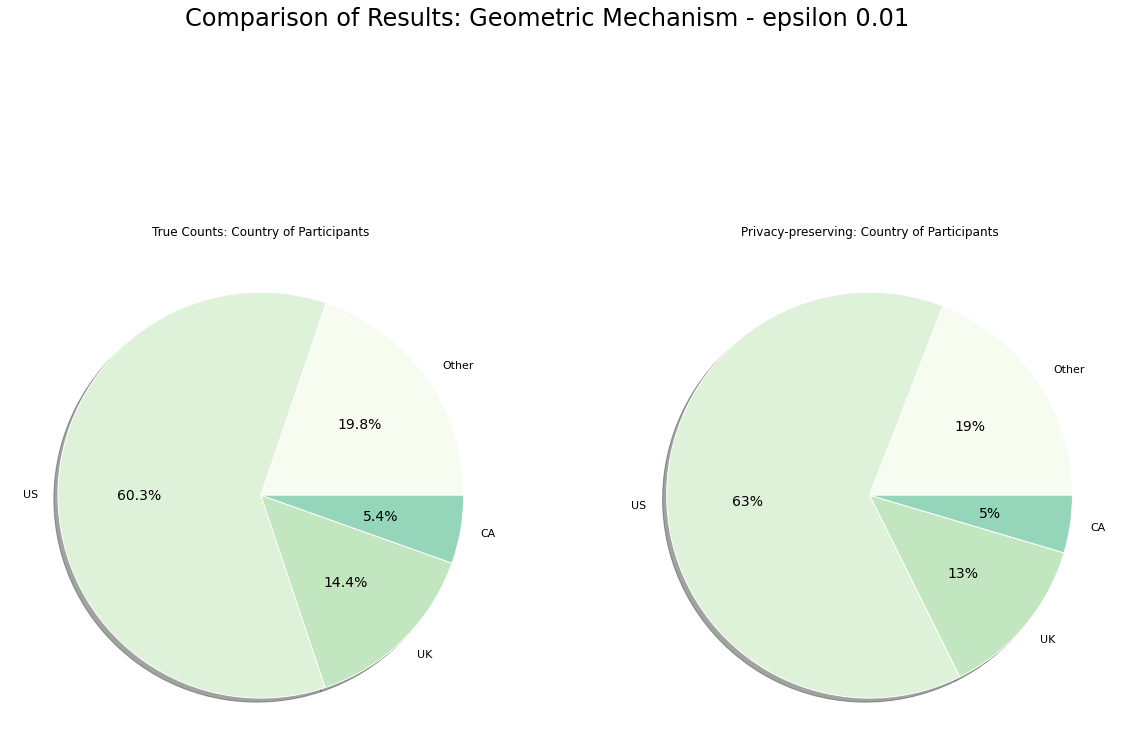

In [19]:
country_true = [ 240, 732, 175, 66]
country_geo = country_histogram.value
epsilon_ = 0.01
country_labels = ['Other','US', 'UK','CA' ]
title = 'Comparison of Results: Geometric Mechanism - epsilon '+str(epsilon_)
subtitle1 = 'True Counts: Country of Participants'
subtitle2 = 'Privacy-preserving: Country of Participants'
pie_comparison(country_labels, country_true, country_geo, title, subtitle1, subtitle2)

## Gender Distribution

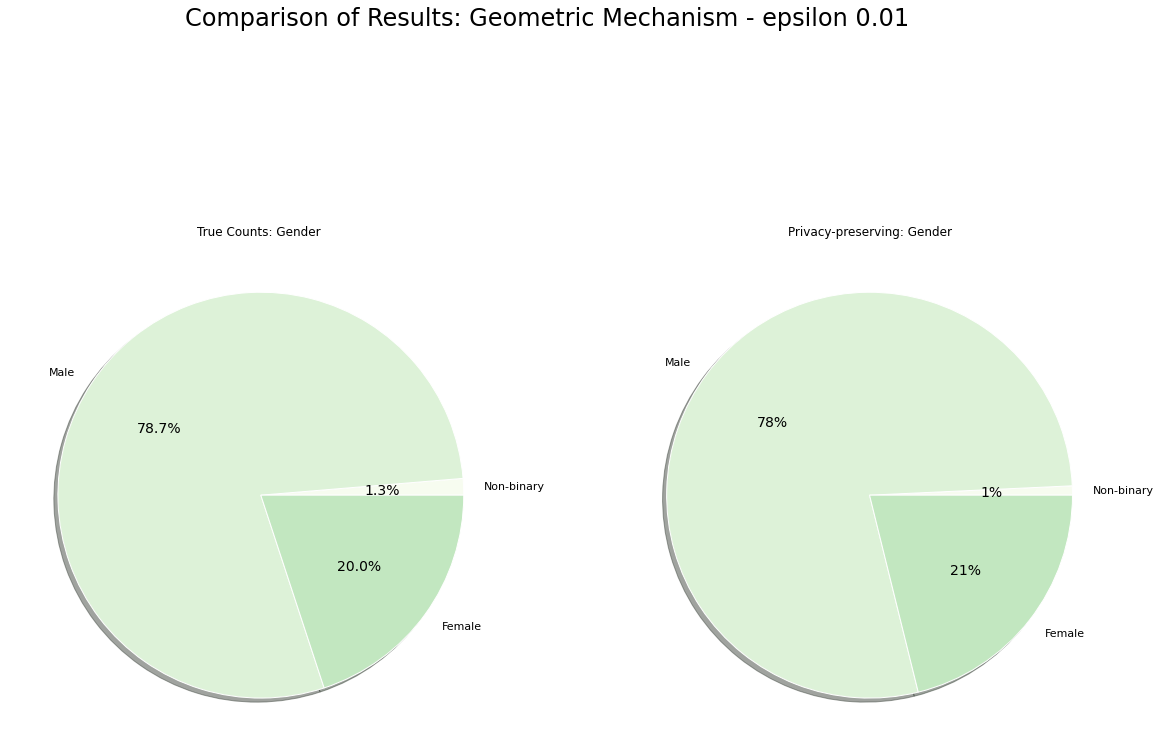

In [22]:
gender_true = [16, 955, 242]
gender_geo = gender_histogram.value
epsilon_ = 0.01
gender_labels = ['Non-binary', 'Male', 'Female']
title = 'Comparison of Results: Geometric Mechanism - epsilon '+str(epsilon_)
subtitle1 = 'True Counts: Gender '
subtitle2 = 'Privacy-preserving: Gender'
pie_comparison(gender_labels, gender_true, gender_geo, title, subtitle1, subtitle2)

### Remote work distribution

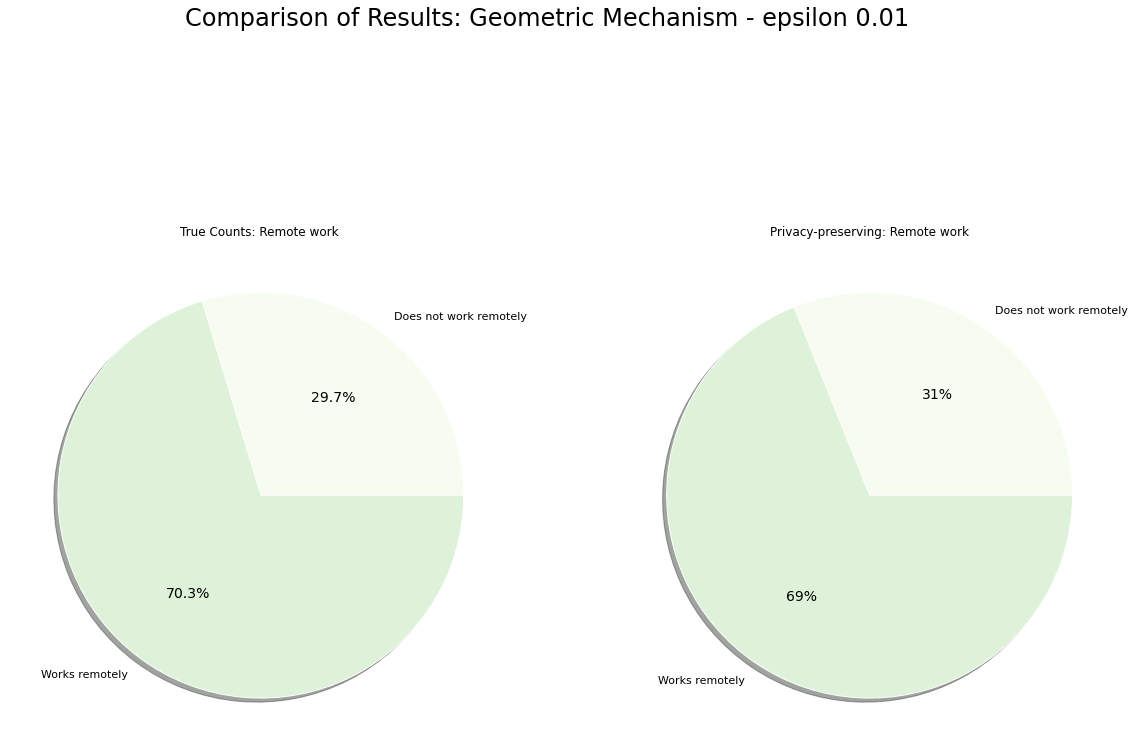

In [23]:
remote_true = [360, 853]
remote_geo = remotework_histogram.value
epsilon_ = 0.01
remote_labels = ['Does not work remotely', 'Works remotely' ]
title = 'Comparison of Results: Geometric Mechanism - epsilon '+str(epsilon_)
subtitle1 = 'True Counts: Remote work '
subtitle2 = 'Privacy-preserving: Remote work'
pie_comparison(remote_labels, remote_true, remote_geo, title, subtitle1, subtitle2)

### Distribution of participants with family history of mental illness

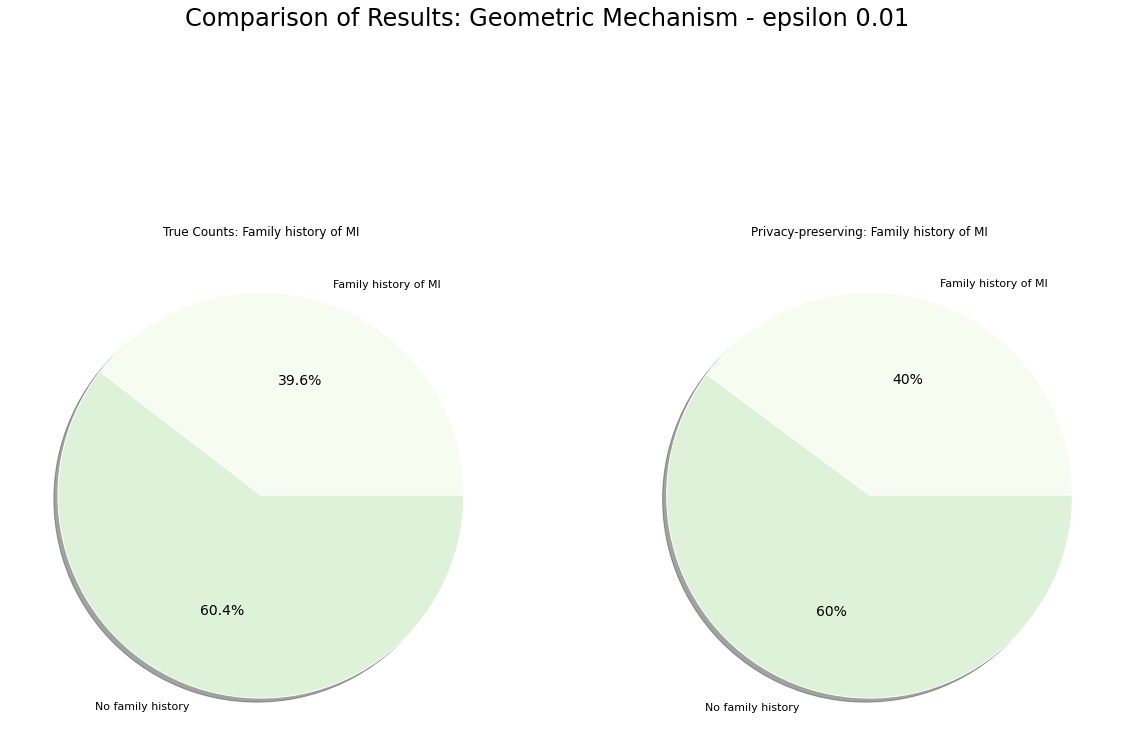

In [24]:
family_true = [480, 733]
family_geo = family_histogram.value
epsilon_ = 0.01
family_labels = ['Family history of MI','No family history']

title = 'Comparison of Results: Geometric Mechanism - epsilon '+str(epsilon_)
subtitle1 = 'True Counts: Family history of MI'
subtitle2 = 'Privacy-preserving: Family history of MI'
pie_comparison(family_labels, family_true, family_geo, title, subtitle1, subtitle2)

### Distribution of participants diagnosed with dental illness

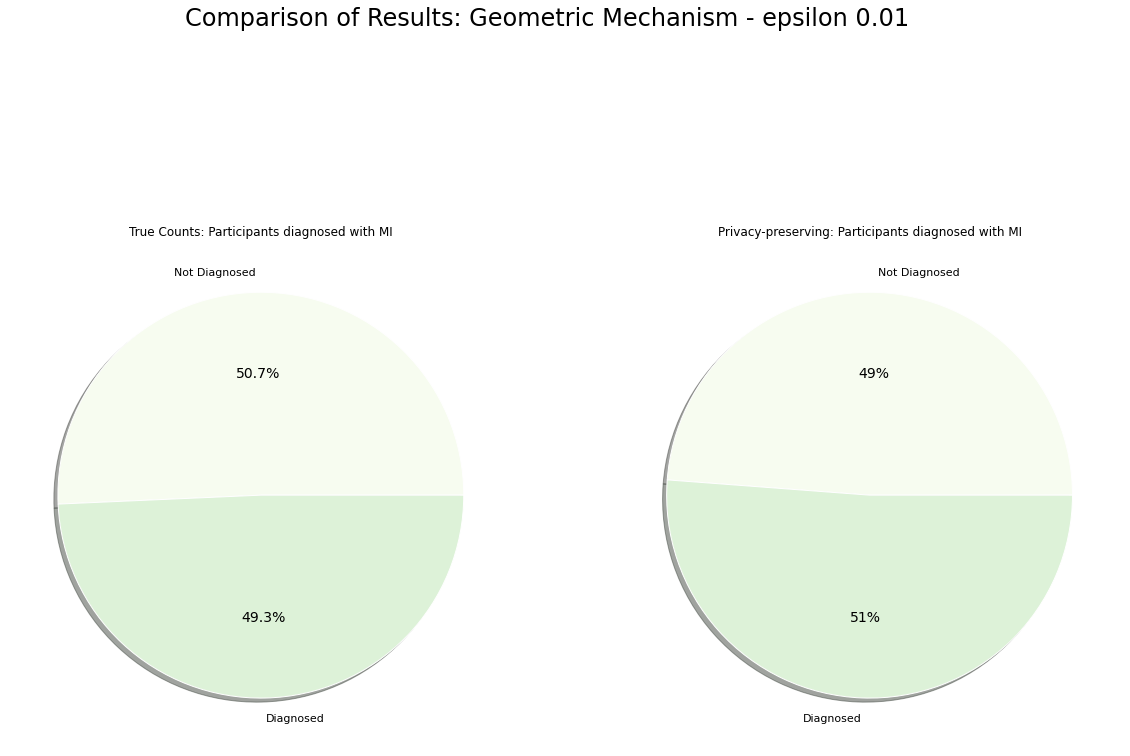

In [25]:
treatment_true = [615, 598]
treatment_geo = treatment_histogram.value
epsilon_ = 0.01
treatment_labels = ['Not Diagnosed','Diagnosed']

title = 'Comparison of Results: Geometric Mechanism - epsilon '+str(epsilon_)
subtitle1 = 'True Counts: Participants diagnosed with MI'
subtitle2 = 'Privacy-preserving: Participants diagnosed with MI'
pie_comparison(treatment_labels, treatment_true, treatment_geo, title, subtitle1, subtitle2)

### 2.2 Variable Interactions

For the queries in the following analysis, we will make histogram queries of disjoint subsets of the data.

Due to parallel composition, when queries are applied to disjoint subsets of the data, the privacy guarantee depends only on the maximum $\epsilon_i$, not the sum.

In [204]:
epsilon_ = 0.4
with wn.Analysis() as analysis:
    data = wn.Dataset(path = path, column_names = var_names)
    
    ## percentage of patients 
    ##that received treatment in each Age class
    
    filter_age4 =  op.filter(data['treatment'], mask = data['age'] == '4')
    age4_histogram = op.dp_histogram(
            op.cast(filter_age4, type='bool', true_label="0"),
            upper = 6,
            privacy_usage = {'epsilon': epsilon_}
        )
    filter_age3 =  op.filter(data['treatment'], mask = data['age'] == '3')
    age3_histogram = op.dp_histogram(
            op.cast(filter_age3, type='bool', true_label="0"),
            upper = 26,
            privacy_usage = {'epsilon': epsilon_}
        )
    filter_age2 =  op.filter(data['treatment'], mask = data['age'] == '2')
    age2_histogram = op.dp_histogram(
            op.cast(filter_age2, type='bool', true_label="0"),
            upper = 149,
            privacy_usage = {'epsilon': epsilon_}
        )
    filter_age1 =  op.filter(data['treatment'], mask = data['age'] == '1')
    age1_histogram = op.dp_histogram(
            op.cast(filter_age1, type='bool', true_label="0"),
            upper = 554,
            privacy_usage = {'epsilon': epsilon_}
        )
    filter_age0 =  op.filter(data['treatment'], mask = data['age'] == '0')
    age0_histogram = op.dp_histogram(
            op.cast(filter_age0, type='bool', true_label="0"),
            upper = 478,
            privacy_usage = {'epsilon': epsilon_}
        )
    
    
    ## percentage of patients 
    ##that received treatment in each Gender class 
    filter_gender2 =  op.filter(data['treatment'], mask = data['gender'] == '2')
    gender2_histogram = op.dp_histogram(
            op.cast(filter_gender2, type='bool', true_label="0"),
            upper = 242,
            privacy_usage = {'epsilon': epsilon_}
        )
    filter_gender1 =  op.filter(data['treatment'], mask = data['gender'] == '1')
    gender1_histogram = op.dp_histogram(
            op.cast(filter_gender1, type='bool', true_label="0"),
            upper = 955,
            privacy_usage = {'epsilon': epsilon_}
        )
    filter_gender0 =  op.filter(data['treatment'], mask = data['gender'] == '0')
    gender0_histogram = op.dp_histogram(
            op.cast(filter_gender0, type='bool', true_label="0"),
            upper = 16,
            privacy_usage = {'epsilon': epsilon_}
        )
    
    
    
    ## percentage of patients 
    ##that received treatment in each country class 
    filter_country3 =  op.filter(data['treatment'], mask = data['country'] == '3')
    country3_histogram = op.dp_histogram(
            op.cast(filter_country3, type='bool', true_label="0"),
            upper = 66,
            privacy_usage = {'epsilon': epsilon_}
        )
    filter_country2 =  op.filter(data['treatment'], mask = data['country'] == '2')
    country2_histogram = op.dp_histogram(
            op.cast(filter_country2, type='bool', true_label="0"),
            upper = 175,
            privacy_usage = {'epsilon': epsilon_}
        )
    filter_country1 =  op.filter(data['treatment'], mask = data['country'] == '1')
    country1_histogram = op.dp_histogram(
            op.cast(filter_country1, type='bool', true_label="0"),
            upper = 732,
            privacy_usage = {'epsilon': epsilon_}
        )
    filter_country0 =  op.filter(data['treatment'], mask = data['country'] == '0')
    country0_histogram = op.dp_histogram(
            op.cast(filter_country0, type='bool', true_label="0"),
            upper = 240,
            privacy_usage = {'epsilon': epsilon_}
        )
    
    
    ## percentage of patients 
    ##that received treatment in each class of remote work
    filter_remote =  op.filter(data['treatment'], mask = data['remote_work'] == '0')
    remote0_histogram = op.dp_histogram(
            op.cast(filter_remote, type='bool', true_label="0"),
            upper = 853,
            privacy_usage = {'epsilon': epsilon_}
        )
    
    filter_remote2 =  op.filter(data['treatment'], mask = data['remote_work'] == '1')
    remote1_histogram = op.dp_histogram(
            op.cast(filter_remote2, type='bool', true_label="0"),
            upper = 360,
            privacy_usage = {'epsilon': epsilon_}
        )
    

    ## percentage of patients 
    ##that received treatment in each class of family history
    filtered =  op.filter(data['treatment'], mask = data['family_history'] == '0')
    family0_histogram = op.dp_histogram(
            op.cast(filtered, type='bool', true_label="0"),
            upper = 733,
            privacy_usage = {'epsilon': epsilon_}
        )
    
    filtered2 =  op.filter(data['treatment'], mask = data['family_history'] == '1')
    family1_histogram = op.dp_histogram(
            op.cast(filtered2, type='bool', true_label="0"),
            upper = 480,
            privacy_usage = {'epsilon': epsilon_}
        )
    
  

analysis.release()


Disposing all query results as a dataframe for our analysis. This dataframe will represent a contingency table that will display the frequency distribution of the variables.

Contigency tables are heavily used in survey statistics, business intelligence, engineering and scientific research.

The contingency table will allow us to explore the interrelations between two variables and also compute the Cramer's V coefficient, which is a statistic used to measure the strengh of association between two vaiables.

In [205]:
dpage0 = np.absolute(age0_histogram.value)
dpage1 = np.absolute(age1_histogram.value)
dpage2 = np.absolute(age2_histogram.value)
dpage3 = np.absolute(age3_histogram.value)
dpage4 = np.absolute(age4_histogram.value)

age0 = survey[survey.age == 0].treatment.value_counts(sort=False)
age1 = survey[survey.age == 1].treatment.value_counts(sort=False)
age2 = survey[survey.age == 2].treatment.value_counts(sort=False)
age3 = survey[survey.age == 3].treatment.value_counts(sort=False)
age4 = survey[survey.age == 4].treatment.value_counts(sort=False)

d1 = {'Group': ['21-30', '31-40', '41-50', '50-60', '60+','21-30', '31-40', '41-50', '50-60', '60+'],
     'Process':['true value', 'true value','true value','true value','true value','privacy-preserving','privacy-preserving','privacy-preserving','privacy-preserving','privacy-preserving'],
     'Participants on treatment MI':[ age0[1], age1[1], age2[1], age3[1], age4[1],dpage0[1], dpage1[1], dpage2[1], dpage3[1], dpage4[1]],
     'Participants not on treatment MI':[ age0[0], age1[0], age2[0], age3[0], age4[0],dpage0[0], dpage1[0], dpage2[0], dpage3[0], dpage4[0]],
     'Variable': 'Age'} 

age_df = pd.DataFrame(data=d1)

gender0 = survey[survey.gender == 0].treatment.value_counts(sort=False)
gender1 = survey[survey.gender == 1].treatment.value_counts(sort=False)
gender2 = survey[survey.gender == 2].treatment.value_counts(sort=False)

dpgender0 = np.absolute(gender0_histogram.value)
dpgender1 = np.absolute(gender1_histogram.value)
dpgender2 = np.absolute(gender2_histogram.value)

d5 = {'Group': ['Non-binary','Male', 'Female', 'Non-binary','Male', 'Female'],
     'Process':['true value', 'true value','true value','privacy-preserving','privacy-preserving','privacy-preserving'],
     'Participants on treatment MI':[ gender0[1], gender1[1], gender2[1],dpgender0[1], dpgender1[1], dpgender2[1]],
     'Participants not on treatment MI':[ gender0[0], gender1[0], gender2[0],dpgender0[0], dpgender1[0], dpgender2[0]],
     'Variable':'Gender'} 

gender_df = pd.DataFrame(data=d5)


country0 = survey[survey.country == 0].treatment.value_counts(sort=False)
country1 = survey[survey.country == 1].treatment.value_counts(sort=False)
country2 = survey[survey.country == 2].treatment.value_counts(sort=False)
country3 = survey[survey.country == 3].treatment.value_counts(sort=False)

dpcountry0 = np.absolute(country0_histogram.value)
dpcountry1 = np.absolute(country1_histogram.value)
dpcountry2 = np.absolute(country2_histogram.value)
dpcountry3 = np.absolute(country3_histogram.value)

d2 = {'Group': ['Other','US', 'UK','CA' ,'Other','US', 'UK','CA' ],
     'Process':['true value', 'true value','true value','true value','privacy-preserving','privacy-preserving','privacy-preserving','privacy-preserving'],
     'Participants on treatment MI':[ country0[1], country1[1], country2[1], country3[1],dpcountry0[1], dpcountry1[1], dpcountry2[1], dpcountry3[1]],
     'Participants not on treatment MI':[ country0[0], country1[0], country2[0], country3[0],dpcountry0[0], dpcountry1[0], dpcountry2[0], dpcountry3[0]],
     'Variable':'Country'} 

country_df = pd.DataFrame(data=d2)

In [206]:
dpremote0 = np.absolute(remote0_histogram.value)
dpremote1 = np.absolute(remote1_histogram.value)
dpfamily0 = np.absolute(family0_histogram.value)
dpfamily1 = np.absolute(family1_histogram.value)

remote0 = survey[survey.remote_work == 0].treatment.value_counts(sort=False)
remote1 = survey[survey.remote_work == 1].treatment.value_counts(sort=False)
family0 = survey[survey.family_history == 0].treatment.value_counts(sort=False)
family1 = survey[survey.family_history == 1].treatment.value_counts(sort=False)

d3 = {'Group': ['Does not work remotely', 'Works remotely', 'Does not work remotely', 'Works remotely'],
     'Process':['true value', 'true value','privacy-preserving','privacy-preserving'],
     'Participants on treatment MI':[ remote0[1], remote1[1],dpremote0[1], dpremote1[1]],
     'Participants not on treatment MI':[ remote0[0], remote1[0],dpremote0[0], dpremote1[0]],
     'Variable': 'Remote work'} 

remote_df = pd.DataFrame(data=d3)

d4 = {'Group': ['No family history','Family history of MI','No family history','Family history of MI'],
     'Process':['true value', 'true value','privacy-preserving','privacy-preserving'],
     'Participants on treatment MI':[ family0[1], family1[1], dpfamily0[1], dpfamily1[1]],
     'Participants not on treatment MI':[ family0[0], family1[0], dpfamily0[0], dpfamily1[0]],
     'Variable': 'Family history'} 

family_df = pd.DataFrame(data=d4)

In [207]:
dfs = [age_df, gender_df, country_df, remote_df, family_df]
DF = pd.concat(dfs)
DF['percentage'] = DF['Participants on treatment MI']*100/(DF['Participants not on treatment MI']+DF['Participants on treatment MI'])

## Observation 1

Participants with family history of mental illness are twice as likely to be diagnosed with mental illness, when compared with participants with no family history.

In [208]:
DF[DF.Variable == 'Family history'].sort_values(['Group'])

,Group,Process,Participants on treatment MI,Participants not on treatment MI,Variable,percentage
1,Family history of MI,true value,357,123,Family history,74.375000
3,Family history of MI,privacy-preserving,354,130,Family history,73.140496
0,No family history,true value,258,475,Family history,35.197817
2,No family history,privacy-preserving,253,494,Family history,33.868809


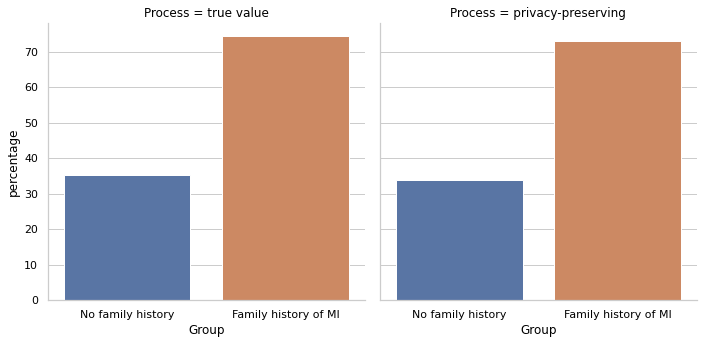

In [209]:
sns.catplot("Group", "percentage", col="Process", data=DF[DF.Variable == 'Family history'], kind="bar")

### Observation 2

participants working remotetly have the same probably of being diagnosed with mental illness as participants that do not work remotely.

In [210]:
DF[DF.Variable == 'Remote work'].sort_values(['Group'])

,Group,Process,Participants on treatment MI,Participants not on treatment MI,Variable,percentage
0,Does not work remotely,true value,424,429,Remote work,49.706917
2,Does not work remotely,privacy-preserving,419,429,Remote work,49.410377
1,Works remotely,true value,191,169,Remote work,53.055556
3,Works remotely,privacy-preserving,209,159,Remote work,56.793478


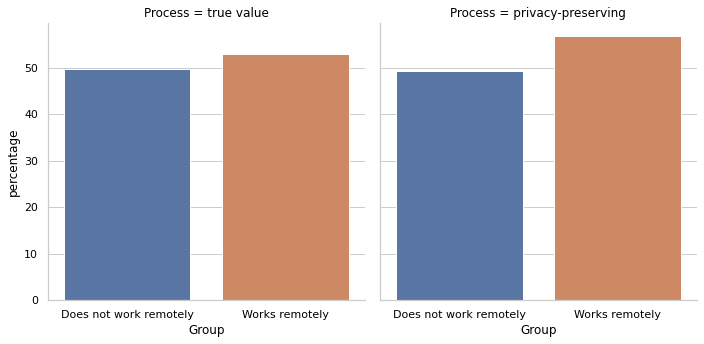

In [211]:
sns.catplot("Group", "percentage", col="Process", data=DF[DF.Variable == 'Remote work'], kind="bar")

# Privacy by design

An adversarial researcher might try to drill down the data in order to get information about specific survey participants.

Differential privacy mechanisms are designed to address such queries with suficient noise to mask the participation of any individual.

In scenarios without a trusted curator, the WhiteNoise library provides accuracy intervals to the researcher. An $\alpha$-level accuracy guarantee a promise that (with probability $1-\alpha$)

$$
M(D) \in [M_{DP}(D)-a, M_{DP}(D)+a]
$$

where $M(D)$ is the query response of function $M$ on database $D$ without differential privacy, and $M_{DP}(D)$ is the response with differential privacy.

Accuracy pitfalls and edge cases are discussed in [this notebook](insert link)

## Observation 3

The US has the biggest percent of professionals in the tech industry diagnosed with mental illness, around 54%. Other countries have the lowest percentage, less than 40%. of tech workers have been treated for mental illness.

In [212]:
DF[DF.Variable == 'Country'].sort_values(['Group'])

,Group,Process,Participants on treatment MI,Participants not on treatment MI,Variable,percentage
3,CA,true value,34,32,Country,51.515152
7,CA,privacy-preserving,32,22,Country,59.259259
0,Other,true value,93,147,Country,38.750000
4,Other,privacy-preserving,99,153,Country,39.285714
2,UK,true value,88,87,Country,50.285714
6,UK,privacy-preserving,91,94,Country,49.189189
1,US,true value,400,332,Country,54.644809
5,US,privacy-preserving,403,329,Country,55.054645


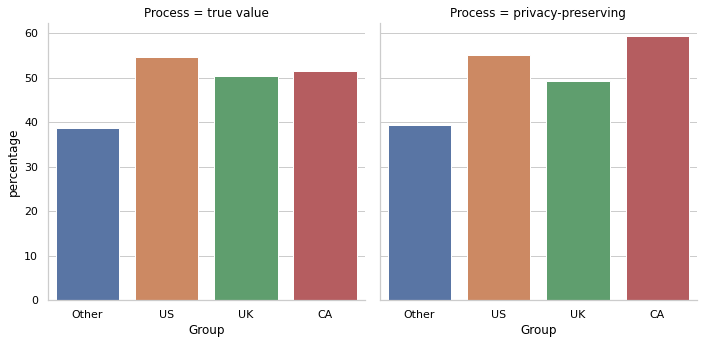

In [213]:
sns.catplot("Group", "percentage", col="Process", data=DF[DF.Variable == 'Country'], kind="bar")

## Observation 4

As we explore the percentage of participants in each age group that seeked MI treatment, we observe that very similar conclusions can be drawn from true values and from privacy preserving values. The exception in for age group of participants 60+ years old. 

As expected, in very small data partitions the distortions are greater.


In [214]:
DF[DF.Variable == 'Age'].sort_values(['Group'])

,Group,Process,Participants on treatment MI,Participants not on treatment MI,Variable,percentage
0,21-30,true value,225,253,Age,47.071130
5,21-30,privacy-preserving,223,258,Age,46.361746
1,31-40,true value,285,269,Age,51.444043
6,31-40,privacy-preserving,288,270,Age,51.612903
2,41-50,true value,87,62,Age,58.389262
7,41-50,privacy-preserving,103,51,Age,66.883117
3,50-60,true value,15,11,Age,57.692308
8,50-60,privacy-preserving,21,10,Age,67.741935
4,60+,true value,3,3,Age,50.000000
9,60+,privacy-preserving,3,3,Age,50.000000


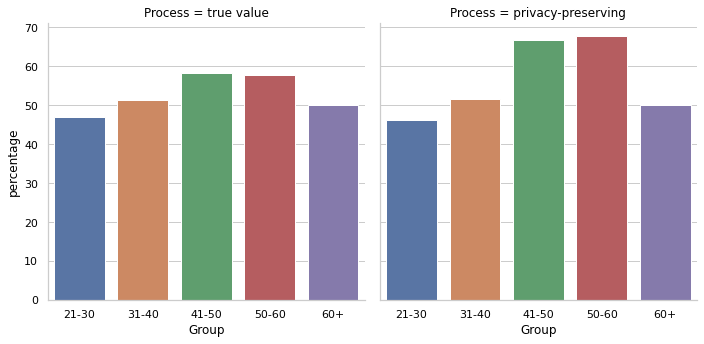

In [215]:
sns.catplot("Group", "percentage", col="Process", data=DF[DF.Variable == 'Age'], kind="bar")

# Comparing associations between variables
### Different variables and variable 'treatment for MI'

## Intercorrelation of two discrete variables

Cramér's V,sometimes referred to as Cramér's phi (denoted as φc), it is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). It is based on Pearson's chi-squared statistic.

φc is the intercorrelation of two discrete variables. and may be used with variables having two or more levels. φc is a symmetrical measure, it does not matter which variable we place in the columns and which in the rows. Also, the order of rows/columns doesn't matter, so φc may be used with nominal data types or higher (notably ordered or numerical).

Source: Wikipedia

In [216]:
def cramers_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = sum(confusion_matrix.sum())
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [217]:
Coefs_var = ['Family history', 'Gender', 'Remote work', 'Age', 'Country'] 

In [218]:
coefs = []
dpcoefs = []
for variable in Coefs_var:
    coefs.append(cramers_stat(DF[(DF.Variable == variable)&(DF.Process == 'true value')][['Participants on treatment MI', 'Participants not on treatment MI']]))
    dpcoefs.append(cramers_stat(DF[(DF.Variable == variable)&(DF.Process == 'privacy-preserving')][['Participants on treatment MI', 'Participants not on treatment MI']]))


In [219]:
c = {'True Coef': coefs,
        'Privacy Coef':dpcoefs}
cramer_coef = pd.DataFrame(data=c, index = Coefs_var)

In [220]:
cramer_coef

,True Coef,Privacy Coef
Family history,0.380581,0.381112
Gender,0.196000,0.221284
Remote work,0.002006,0.059553
Age,0.046954,0.124001
Country,0.112341,0.119204
